(754, 1508, 3)


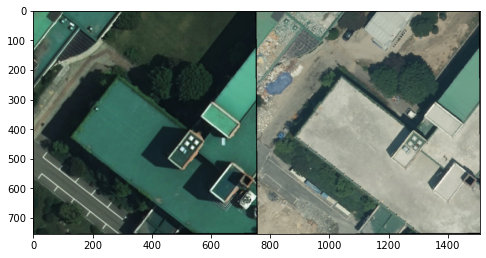

In [187]:
import mmcv
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
import cv2

img = mmcv.imread('data/train/x/2015_DMG_1LB_000006.png')


# print(len(img[0 == img ]))
# print(len(img[1 == img ]))
# print(len(img[2 == img]))
# print(len(img[3 == img ]))
print(img.shape)
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [188]:
data_root = 'data'
img_dir = 'x'
ann_dir = 'y'

In [189]:
# import os.path as osp
# import numpy as np
# from PIL import Image
# # convert dataset annotation to semantic segmentation map
# # split train/val set randomly

# split_dir = 'splits'
# mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
#     osp.join(data_root, ann_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*4/5)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

In [190]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
import os.path as osp

classes = ('background', 'new', 'destroy', 'upgrade')
palette = [[0, 0, 0], [0, 0, 128], [128, 0, 0],[0, 128, 0]]

@DATASETS.register_module()
class MAICONDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

KeyError: 'MAICONDataset is already registered in dataset'

In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [6]:
# config_file = 'configs/swin/upernet_swin_small_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py' # mIoU 26.5?
# config_file = 'configs/swin/upernet_swin_large_patch4_window7_512x512_pretrain_224x224_22K_160k_ade20k.py'
config_file = 'configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K.py' #  Tiny
checkpoint_file = 'checkpoints/iter_80003_0.411.pth'

In [7]:
# # build the model from a config file and a checkpoint file
# model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

In [8]:
# # test a single image
# img = 'demo/demo.png'
# result = inference_segmentor(model, img)

In [9]:
# # show the results
# show_result_pyplot(model, img, result, get_palette('ade20k'))

In [10]:
from mmcv import Config
cfg = Config.fromfile(config_file)

In [11]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.l_norm_cfg = dict(type='LN', requires_grad=True) # for ViT backbone
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.l_norm_cfg
# cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 4
cfg.model.auxiliary_head.num_classes = 4

# Modify dataset type and path
cfg.dataset_type = 'MAICONDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (378, 378)
image_scale = (754, 378)
# cfg.crop_size = (256, 256)
# image_scale = (480, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=image_scale, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=image_scale,
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = 'train/'+img_dir
cfg.data.train.ann_dir = 'train/'+ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'train/splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = 'train/'+img_dir
cfg.data.val.ann_dir = 'train/'+ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'train/splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = 'test/'+img_dir
cfg.data.test.ann_dir = 'test/'+ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'test/splits/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
# cfg.work_dir = './work_dirs/maicon/swin_small_patch4_window7_512x512_160k_ade20k_4'
cfg.work_dir = '/data/pytorch/experiments_ViT/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K'

# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000) 

cfg.runner.max_iters = 200000
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 1000

cfg.optimizer.lr = 1e-22 # default 6e-05

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
backbone_norm_cfg = dict(type='LN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='SwinTransformer',
        pretrain_img_size=224,
        embed_dims=96,
        patch_size=4,
        window_size=7,
        mlp_ratio=4,
        depths=[2, 2, 6, 2],
        num_heads=[3, 6, 12, 24],
        strides=(4, 2, 2, 2),
        out_indices=(0, 1, 2, 3),
        qkv_bias=True,
        qk_scale=None,
        patch_norm=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.3,
        use_abs_pos_embed=False,
        act_cfg=dict(type='GELU'),
        norm_cfg=dict(type='LN', requires_grad=True),
        init_cfg=dict(
            type='Pretrained',
            checkpoint=
            'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/swin/swin_tiny_patch4_window7_224_20220317-1cdeb081.pth'
        )),
    decode_head=dict(
        type='U

In [12]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]
test_dataset = [build_dataset(cfg.data.test)]

# Add an attribute for visualization convenience
cfg.checkpoint_config.meta = dict(
    CLASSES=datasets[0].CLASSES,
    PALETTE=datasets[0].PALETTE)
    
# Build the detector
model = build_segmentor(cfg.model)



2023-08-19 15:26:23,833 - mmseg - INFO - Loaded 9600 images
2023-08-19 15:26:23,838 - mmseg - INFO - Loaded 2338 images


/home/fds/Downloads/Military_AI_CompetitiON/experiments_ViT/ViT/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [13]:
import torch.nn as nn

In [14]:
# # If you want to change backend model, do like this.
# # model.backbone.patch_embed.projection = nn.Sequential( model.backbone.patch_embed.projection, nn.Conv2d(96, 96, kernel_size=(4, 4), stride=(4, 4)))
# model.backbone.patch_embed.projection = nn.Conv2d(6, 96, kernel_size=(4, 4), stride=(4, 4))

In [15]:
model.backbone

SwinTransformer(
  (patch_embed): PatchEmbed(
    (adap_padding): AdaptivePadding()
    (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (drop_after_pos): Dropout(p=0.0, inplace=False)
  (stages): ModuleList(
    (0): SwinBlockSequence(
      (blocks): ModuleList(
        (0): SwinBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftWindowMSA(
            (w_msa): WindowMSA(
              (qkv): Linear(in_features=96, out_features=288, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=96, out_features=96, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop): DropPath()
          )
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (ffn): FFN(
            (activate): GELU(approxi

## Train

In [16]:
# # Create work_dir
# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
#                 meta=dict())

## Inference

In [17]:
# import os
# files = [f for f in os.listdir(os.getcwd()+"/data/test/x/")]
# files.sort()
# file_name = './data/test/splits/test.txt'
# with open(file_name, 'w') as file:
#     file.write('\n'.join(files))

In [18]:
from mmseg.apis import init_segmentor, show_result_pyplot
from mmseg.apis.inference_MAICON import inference_segmentor_MAICON
from mmseg.core.evaluation import get_palette

In [19]:
# config_file = 'configs/swin/upernet_swin_tiny_patch4_window7_512x512_160k_ade20k_pretrain_224x224_1K_MAICON.py' #  Tiny
# checkpoint_file = 'checkpoints/iter_80001_0.41.pth'

In [191]:
# build the model from a config file and a checkpoint file
model = inference_segmentor_MAICON(cfg, checkpoint_file, device='cuda:0')

/home/fds/Downloads/Military_AI_CompetitiON/experiments_ViT/ViT/mmseg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/iter_80003_0.411.pth


In [202]:
img_x_path = "./data/train/x"
# img = "2017_KRG_2LB_000887.png"
# img = "2017_MPG_2LB_000631.png"
img = "2019_KSG_1JY_000010.png"
x_path = os.path.join(img_x_path,img)

result = inference_segmentor(model, x_path)

img_y_path = "./data/train/y"
y_path = os.path.join(img_y_path,img)

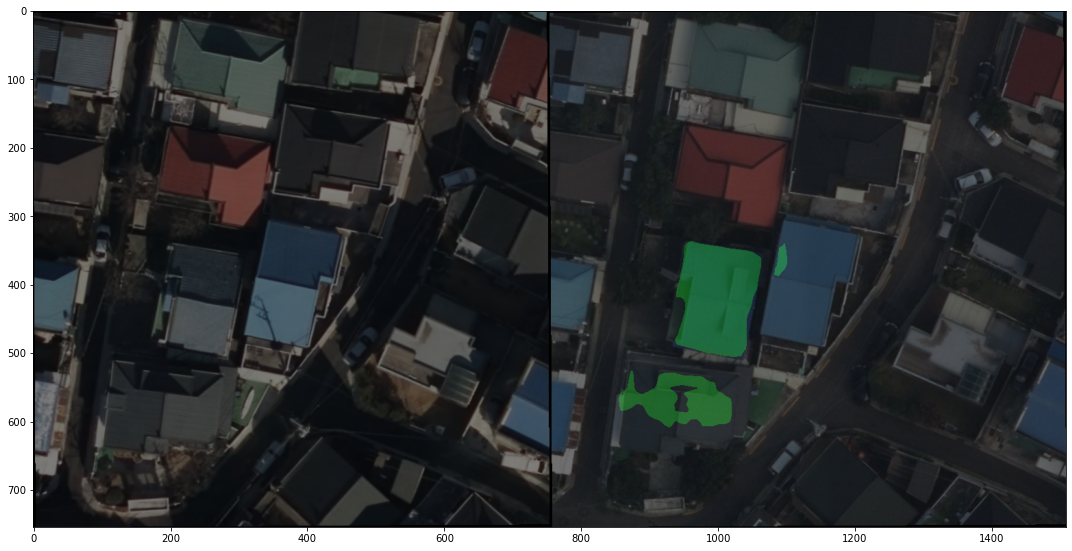

In [203]:
# show the results
show_result_pyplot(model, x_path, result, palette)

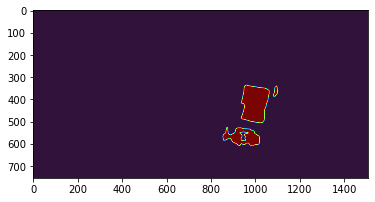

In [204]:
from matplotlib import pyplot as plt
ground_truth = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(ground_truth, cmap='turbo', vmin=0,vmax=3)
plt.imshow(np.squeeze(result, 0), cmap='turbo',vmin=0,vmax=3)

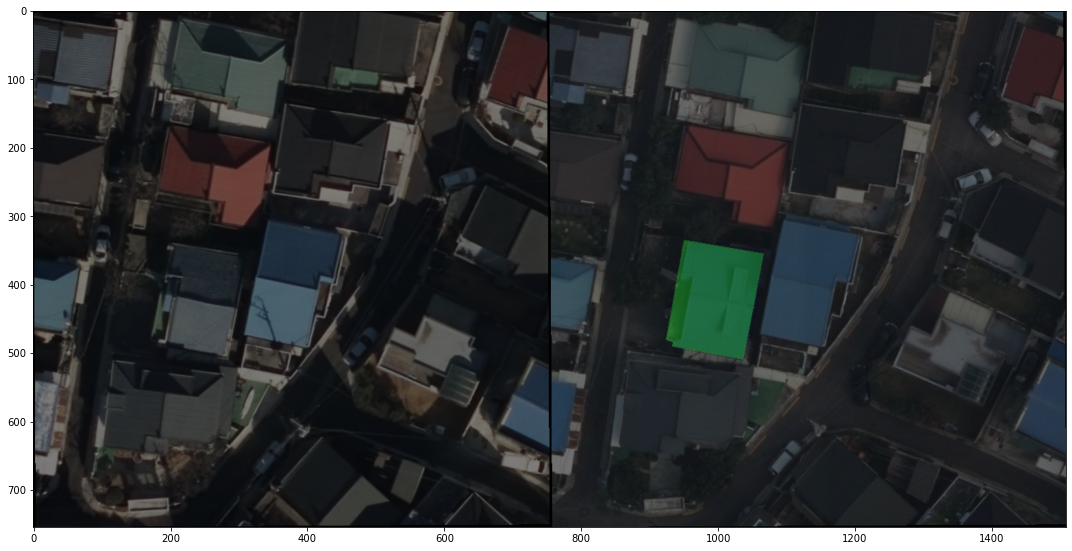

In [205]:
# show the ground-truth
ground_truth = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
ground_truth = torch.FloatTensor(ground_truth)
ground_truth = torch.unsqueeze(ground_truth, 0)
ground_truth = np.array(ground_truth)
show_result_pyplot(model, x_path, ground_truth, palette)

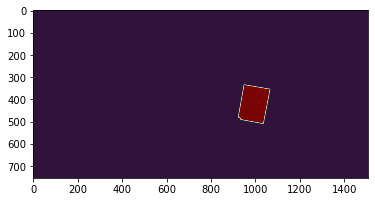

In [206]:
from matplotlib import pyplot as plt
ground_truth = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(ground_truth, cmap='turbo', vmin=0,vmax=3)

### Submit code

In [53]:
import torch
import os
import numpy as np
import cv2

prj_dir = os.getcwd()

for file_name in os.listdir(os.path.join(prj_dir, 'data', 'test', 'x')):

    img = os.path.join(prj_dir, 'data', 'test', 'x', file_name)
    result = inference_segmentor(model, img)
    result = torch.FloatTensor(result)
    result = torch.permute(result, (1, 2, 0))
    result = np.array(result)

    # from torchvision.utils import save_image
    pred_result_dir_mask = os.path.join(prj_dir, 'results', 'pred', 'mask')
    os.makedirs(pred_result_dir_mask, exist_ok=True)

    # save_image(result, os.path.join(pred_result_dir_mask, "1076.png"))

    cv2.imwrite(os.path.join(pred_result_dir_mask, file_name), result)
